In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_channle, output_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, output_dim)
        )
    def forward(self,x):
        x=self.net(x)
        return x

cuda


In [3]:
class BranchNetwork(nn.Module):
    def __init__(self, input_dim, hidden_channle, output_dim):
        super(BranchNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, output_dim)
        )
    def forward(self, x):
        x=self.net(x)
        return x

class TrunkNetwork(nn.Module):
    def __init__(self, input_dim, hidden_channle, output_dim):
        super(TrunkNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, output_dim)
        )
    def forward(self, x):
        x=self.net(x)
        return x

class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_channle, output_dim):
        super(DeepONet, self).__init__()
        self.branch_net = BranchNetwork(branch_input_dim, hidden_channle, output_dim)
        self.trunk_net = TrunkNetwork(trunk_input_dim, hidden_channle, output_dim)

    def forward(self, branch_input, trunk_input):
        branch_output = self.branch_net(branch_input)
        trunk_output = self.trunk_net(trunk_input)
        s = torch.sum(branch_output * trunk_output,axis=1)
        return s.view(-1,1)

In [4]:
class PINN_Vibratec:
    def __init__(self, model):
        self.model = model
        self.Losses = []
        self.file_name = 'C:\\Users\\Fan\\JupyterFile\\DeepLearning\\PINNs\\PINNs_ElasticMechanics\\DeepONet_Vibrate_1D.pkl'

    def load_model(self):
        self.model.load_state_dict(torch.load(self.file_name))
        
    def u_function(self, bc_data, x_data):
        out = self.model(bc_data, x_data)
        u = out[:,0:1]
        return u

    def data_Loss(self, bc_data, x_data):
        u_pre = self.u_function(bc_data, x_data)
        u_ex = self.u_Exact(bc_data, x_data)
        loss = torch.mean(torch.square(u_pre - u_ex))
        return loss

    def u_Exact(self, bc_data, x_data):
        w = bc_data[:,0:1]
        p = bc_data[:,1:2]
        q = bc_data[:,2:3]
        u = torch.sin(w * x_data + q) * p
        return u

    def get_Train(self, Num=50000, T=1):
        bc_data = np.random.random((Num, 3))
        bc_data[:,0:1] = (bc_data[:,0:1] * 4 - 2) * np.pi  # w
        bc_data[:,1:2] = bc_data[:,1:2] * 4 - 2      # p
        bc_data[:,2:3] = (bc_data[:,2:3] * 2 - 1) * np.pi  # q
        
        Bc_data = torch.tensor(bc_data, dtype=torch.float32, requires_grad=True).to(device)
        
        x_data = np.linspace(0, T, Num).reshape(-1, 1)
        
        X_data = torch.tensor(x_data, dtype=torch.float32, requires_grad=True).to(device)
        return Bc_data, X_data
    
    def train(self, epochs, learning_rate, step_size=400, gamma=0.5):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=step_size, gamma=gamma)
        for epoch in range(epochs):
            if epoch % 100 == 0:
                bc_data, x_data = self.get_Train()
            self.optimizer.zero_grad()
            loss = self.data_Loss(bc_data, x_data)
            loss.backward()
            self.Losses.append(loss.item())
            self.optimizer.step()
            self.scheduler.step()
            if epoch % 100 == 0:
                print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item():.8f}]")
                torch.save(self.model.state_dict(), self.file_name)
        print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item()}]")
        torch.save(self.model.state_dict(), self.file_name)
        print("Current learning rate:", self.optimizer.param_groups[0]['lr'])
        return loss

    def plot_loss(self):
        plt.title('log(loss)')
        plt.plot(np.log(self.Losses), label = 'Loss')
        plt.legend()
        plt.show()
        
    def predict(self, bc_data, x_data):
        u = self.model(bc_data, x_data)
        u = u.cpu().detach().numpy()
        return u
        
    def plot_result(self, bc_data, x_data):
        u_np = self.predict(bc_data, x_data)
        u_ex = self.u_Exact(bc_data, x_data).cpu().detach().numpy()
        x_np = x_data.cpu().detach().numpy()

        print(f"Total Loss:{np.mean(np.square(u_np-u_ex))}")
        
        plt.title('Predict & Exact')
        plt.plot(x_np, u_np, label = 'Predict')
        plt.plot(x_np, u_ex, label = 'Exact', linestyle=':', marker='.')
        plt.legend()
        plt.show()

In [5]:
# bc_data, x_data
T = 1
Num = 50000
def get_Train(Num=Num, T=T):
    bc_data = np.random.random((Num, 3))
    bc_data[:,0:1] = (bc_data[:,0:1] * 3 - 1) * np.pi  # w
    bc_data[:,1:2] = bc_data[:,1:2] * 4 - 2      # p
    bc_data[:,2:3] = (bc_data[:,2:3] * 4 - 2) * np.pi      # q
    
    Bc_data = torch.tensor(bc_data, dtype=torch.float32, requires_grad=True).to(device)
    
    x_data = np.linspace(0, T, Num).reshape(-1, 1)
    
    X_data = torch.tensor(x_data, dtype=torch.float32, requires_grad=True).to(device)
    return Bc_data, X_data
    
def get_Test(w, p, q, T0=0, T1=1, Nt = 200):
    bc_test = np.tile([w,p,q],(Nt,1))
    x_test = np.linspace(T0, T1, Nt).reshape(-1,1)

    Bc_test = torch.tensor(bc_test, dtype=torch.float32, requires_grad=True).to(device)
    X_test = torch.tensor(x_test, dtype=torch.float32, requires_grad=True).to(device)
    return Bc_test, X_test
Bc_test, X_test = get_Test(2,1,1,T0=0,T1=T)

[Epoch 1/100000] [loss: 0.00626238]
[Epoch 101/100000] [loss: 0.20626007]
[Epoch 201/100000] [loss: 0.11848689]
[Epoch 301/100000] [loss: 0.07244303]
[Epoch 401/100000] [loss: 0.05075384]
[Epoch 501/100000] [loss: 0.03971392]
[Epoch 601/100000] [loss: 0.03320569]
[Epoch 701/100000] [loss: 0.02819594]
[Epoch 801/100000] [loss: 0.02551521]
[Epoch 901/100000] [loss: 0.02954627]
[Epoch 1001/100000] [loss: 0.02189293]
[Epoch 1101/100000] [loss: 0.02126045]
[Epoch 1201/100000] [loss: 0.02042225]
[Epoch 1301/100000] [loss: 0.01922087]
[Epoch 1401/100000] [loss: 0.01949384]
[Epoch 1501/100000] [loss: 0.04406761]
[Epoch 1601/100000] [loss: 0.01741623]
[Epoch 1701/100000] [loss: 0.01984771]
[Epoch 1801/100000] [loss: 0.09662881]
[Epoch 1901/100000] [loss: 0.01534419]
[Epoch 2001/100000] [loss: 0.04217390]
[Epoch 2101/100000] [loss: 0.01473386]
[Epoch 2201/100000] [loss: 0.01352512]
[Epoch 2301/100000] [loss: 0.01362558]
[Epoch 2401/100000] [loss: 0.01301135]
[Epoch 2501/100000] [loss: 0.01252845

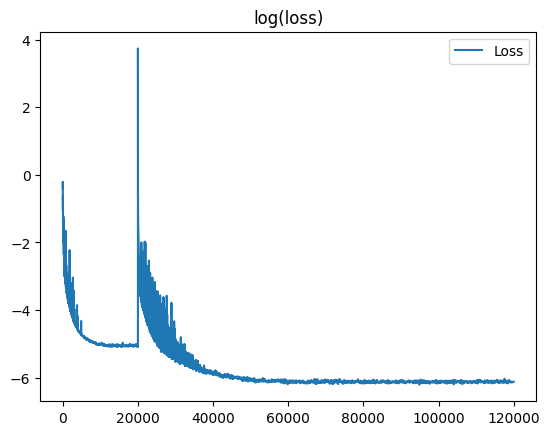

Total Loss:0.007142940536141396


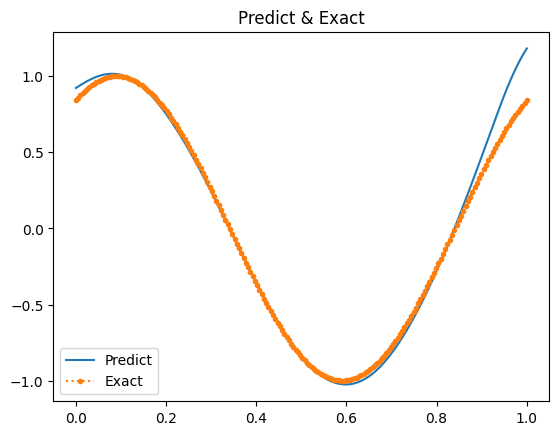

In [10]:
model = DeepONet(3, 1, 100, 200).to(device)
PINNs_model = PINN_Vibratec(model)
loss = PINNs_model.train(epochs = 20000, learning_rate = 1e-3, step_size=1000, gamma=0.5)
PINNs_model.plot_loss()
PINNs_model.plot_result(Bc_test, X_test)
# PINNs_model.load_model()

In [11]:
def plot_test(w,p,q,T):
    T_test = np.linspace(0,long_T,200*long_T)
    Bc_test, X_test = get_Test(w, p, q, T0=0, T1=long_T, Nt=200*long_T)
    U_exact = PINNs_model.u_Exact(Bc_test, X_test).cpu().detach().numpy()
    
    U_pre = np.array([])
    for i in range(long_T):
        n = (q+w*i)//np.pi
        Bc_test, X_test = get_Test(w, p, w*i+q-n*np.pi, T0=0, T1=1)
        u_pre = PINNs_model.predict(Bc_test, X_test)*(-1)**n
        if i==0:
            U_pre = u_pre
        else:
            U_pre = np.vstack((U_pre,u_pre))
        
    error = np.mean(np.square(U_pre-U_exact))
    print(f'Time: 0 - {long_T}  Total Error: {error}')
    fig = plt.figure(figsize=(16, 4))
    plt.plot(T_test, U_exact, label='Exact', color='C0')
    plt.plot(T_test, U_pre, '--', label='Predicted', lw=2, color='C3')
    plt.xlabel('y')
    plt.ylabel('G(u)(y)')
    plt.xlabel('t')
    plt.tight_layout()
    plt.legend()
    plt.show()


Time: 0 - 10  Total Error: 0.007602626923471689


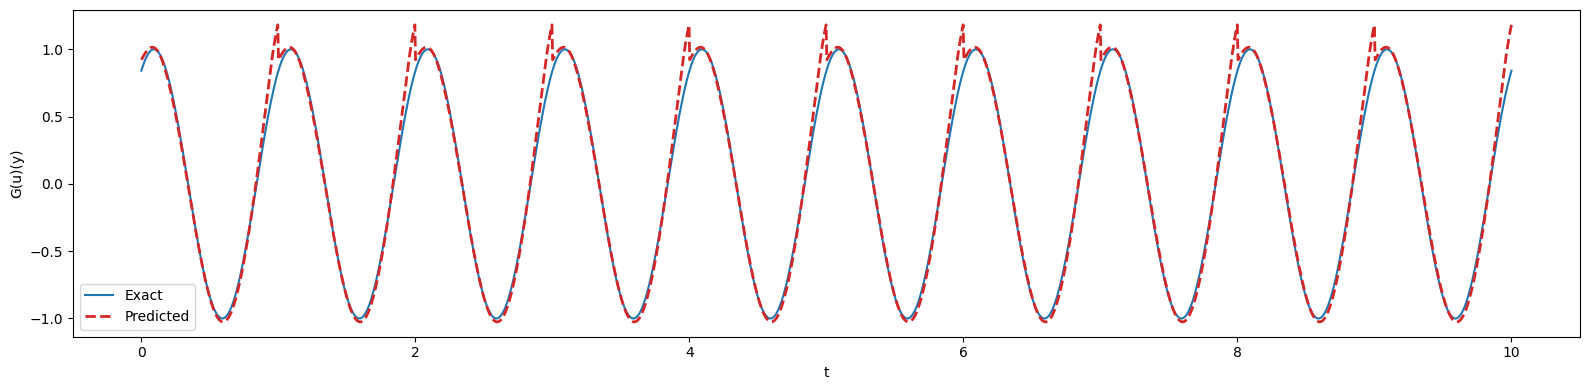

Time: 0 - 10  Total Error: 0.03404580429196358


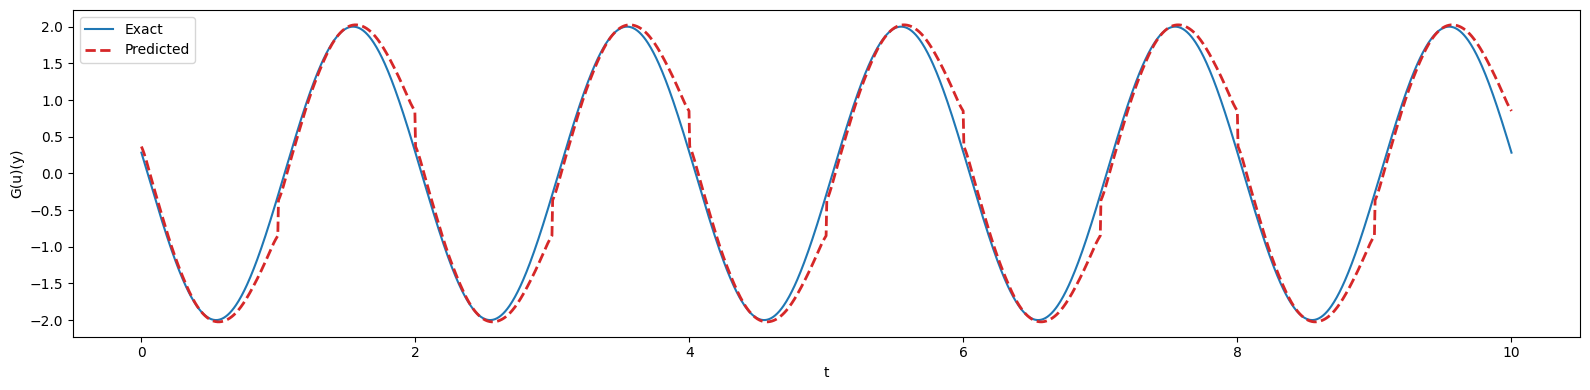

Time: 0 - 10  Total Error: 0.0020246172789484262


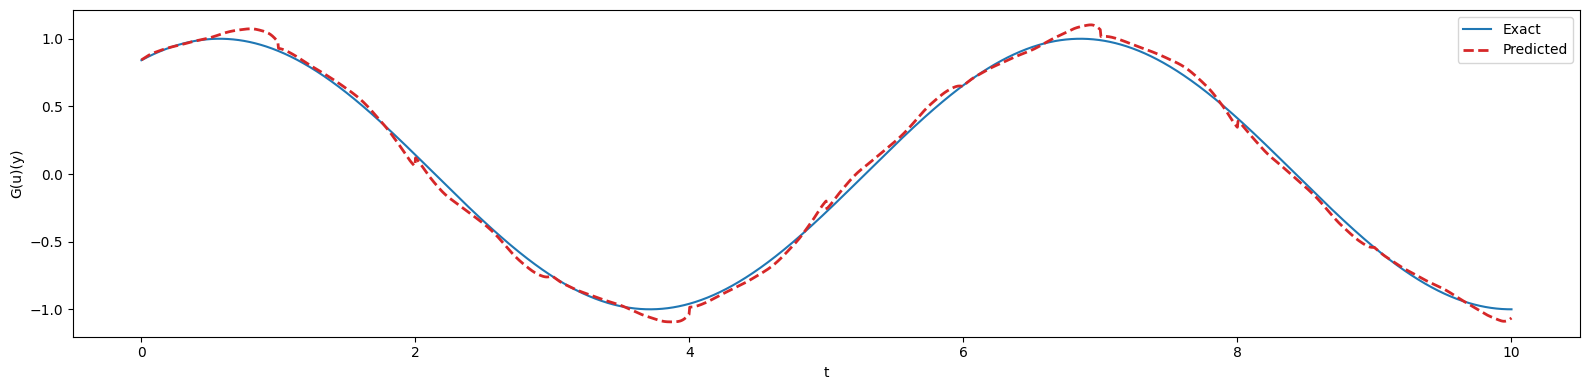

Time: 0 - 10  Total Error: 0.0025124186649918556


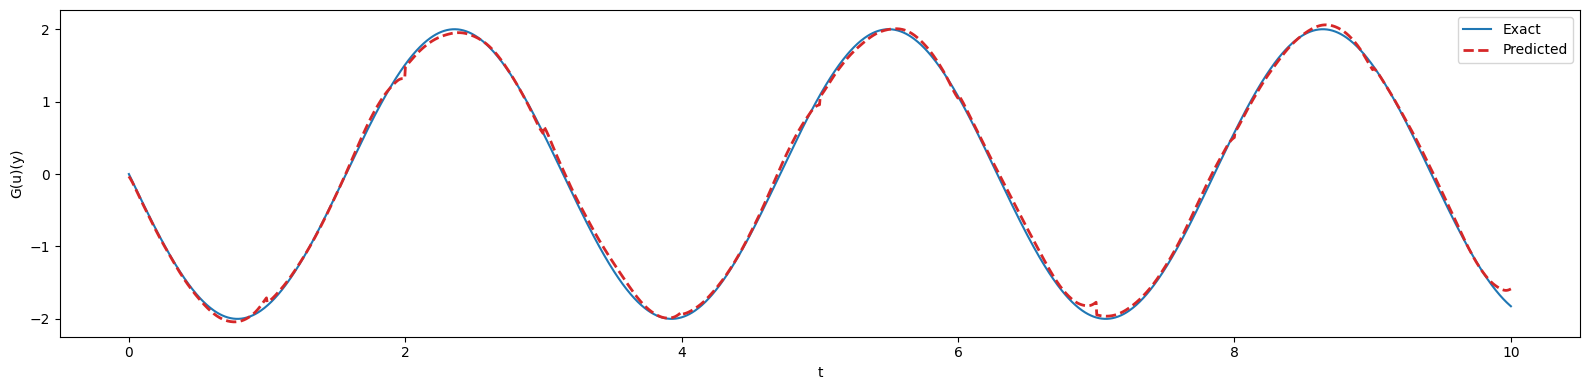

Time: 0 - 10  Total Error: 0.36145344376564026


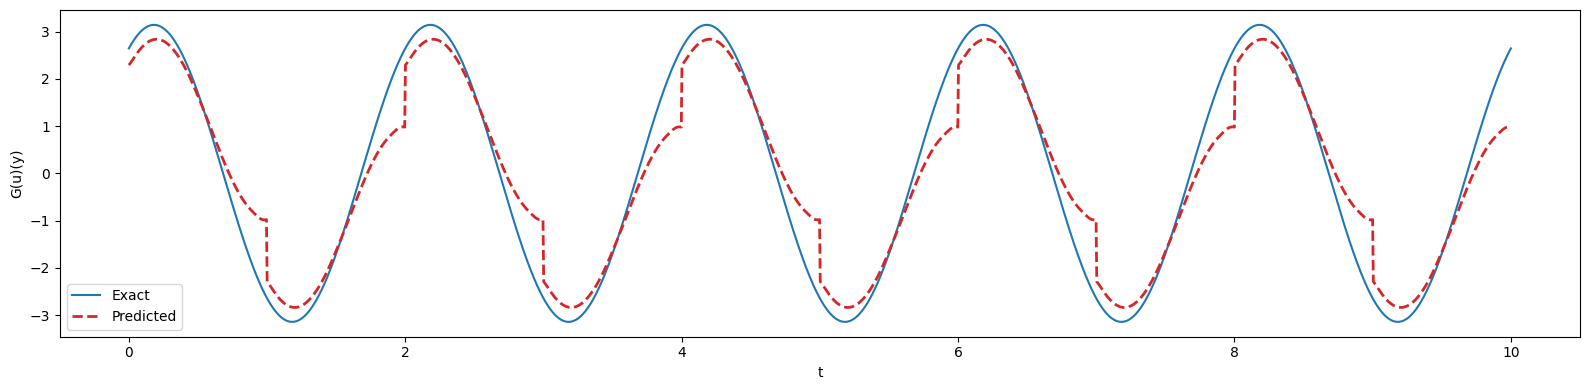

In [13]:
plot_test(np.pi*2,1,1,10)
plot_test(np.pi,2,3,10)
plot_test(1,1,1,10)
plot_test(2,2,np.pi,10)
plot_test(np.pi,np.pi,1,10)